# Power.ipynb

In [127]:
import numpy as np
import math
import copy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ptick
from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import LinearSegmentedColormap  # colormapをカスタマイズする
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import B_JRM33 as BJRM
import B_equator as BEQ
import Leadangle_wave as LeadA
from TScmap import TScmap

# Color universal design
cud4 = ['#FF3300', '#FFF100', '#03AF7A', '#005AFF', '#4DC4FF', '#FF8082', '#F6AA00', '#990099', '#804000']
cud4bs = ['#FFCABF', '#FFFF80', '#D8F255', '#BFE4FF', '#FFCA80', '#77D9A8', '#C9ACE6', '#84919E']

# matplotlib フォント設定
fontname = 'Nimbus Sans'
plt.rcParams.update({'font.sans-serif': fontname,
                     'font.family': 'sans-serif',
                     'mathtext.fontset': 'custom',
                     'mathtext.rm': fontname,
                     'mathtext.it': fontname+':italic',
                     # 'mathtext.bf': 'Nimbus Sans:italic:bold',
                     'mathtext.bf': fontname+':bold',
                     'font.size': 19,
                     })
params = {
    # 'lines.markersize': 1,
    # 'lines.linewidth': 1,
    'axes.linewidth': 2,
    'xtick.major.size': 5,
    'xtick.minor.size': 3.5,
    'xtick.major.width': 2.0,
    'xtick.minor.width': 1.25,
    'ytick.major.size': 5,
    'ytick.minor.size': 3,
    'ytick.major.width': 2.0,
    'ytick.minor.width': 1.25,
}
plt.rcParams.update(params)

In [128]:
# 定数
MOON = 'Europa'
MU0 = 1.26E-6            # 真空中の透磁率
AMU = 1.66E-27           # [kg]
RJ = 71492E+3            # JUPITER RADIUS [m]
RE = 1.56E+6             # MOON RADIUS [m]
C = 2.99792E+8           # 光速 [m/s]
OMGJ = 1.75868E-4        # 木星の自転角速度 [rad/s]
satovalN = np.recfromtxt('data/JRM33/satellite_foot_N.txt', skip_header=3,
                         names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])
satovalS = np.recfromtxt('data/JRM33/satellite_foot_S.txt', skip_header=3,
                         names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

In [129]:
# 定数
RJ = 71492E+3         # JUPITER RADIUS [m]
r_orbit = 9.38*RJ      # ORBITAL RADIUS (average) [m] (Bagenal+2015)
# r_orbit = 5.9*RJ

Psyn_eu = (11.22)*3600      # Moon's synodic period [sec]
OMGR = 2*np.pi/(Psyn_eu)    # Moon's synodic angular velocity [rad/sec]

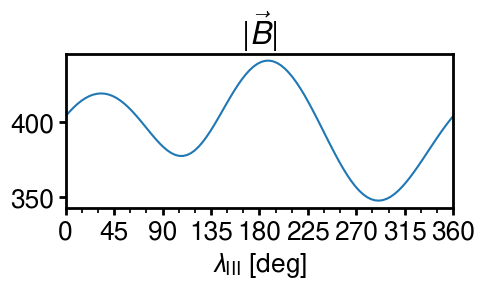

In [130]:
# 衛星公転軌道の磁場強度
S3wlon = np.radians(np.linspace(0, 360, 100))      # [rad]
S3lat = np.zeros(S3wlon.shape)                    # [rad]

theta_arr = 0.5*np.pi-S3lat
phi_arr = 2*np.pi-S3wlon

B = np.zeros(S3wlon.shape)
Br = np.zeros(S3wlon.shape)
Btheta = np.zeros(S3wlon.shape)
Bphi = np.zeros(S3wlon.shape)

x_arr = r_orbit*np.sin(theta_arr)*np.cos(phi_arr)
y_arr = r_orbit*np.sin(theta_arr)*np.sin(phi_arr)
z_arr = r_orbit*np.cos(theta_arr)

for i in range(S3wlon.size):
    theta = theta_arr[i]
    phi = phi_arr[i]
    x = x_arr[i]
    y = y_arr[i]
    z = z_arr[i]

    Bv = BJRM.B().JRM33(r_orbit, theta, phi)*1E-9        # [T]
    Bx = Bv[0]*math.sin(theta)*math.cos(phi) \
        + Bv[1]*math.cos(theta)*math.cos(phi) \
        - Bv[2]*math.sin(phi)
    By = Bv[0]*math.sin(theta)*math.sin(phi) \
        + Bv[1]*math.cos(theta)*math.sin(phi) \
        + Bv[2]*math.cos(phi)
    Bz = Bv[0]*math.cos(theta) - Bv[1]*math.sin(theta)

    Bcs = BJRM.B().BCS(x, y, z, phi)*1E-9  # [T]
    Bx += Bcs[0]
    By += Bcs[1]
    Bz += Bcs[2]

    B0 = math.sqrt(Bx**2+By**2+Bz**2)      # [T]
    Br[i] = Bx*math.sin(theta)*math.cos(phi) \
        +By*math.sin(theta)*math.sin(phi) \
        +Bz*math.cos(theta)
    Btheta[i] = Bx*math.cos(theta)*math.cos(phi) \
        +By*math.cos(theta)*math.sin(phi) \
        -Bz*math.sin(theta)
    Bphi[i] = -Bx*math.sin(phi) + By*math.cos(phi)

    B[i] = B0

fig, ax = plt.subplots(figsize=(5,2))
ax.set_title(r'$|\vec{B}|$')
ax.set_xlabel(r'$\lambda_{\rm III}$ [deg]', fontsize=19)
ax.set_xlim(0,360)
ax.set_xticks(np.arange(0,361,45,dtype=int))
ax.set_xticklabels(np.arange(0,361,45,dtype=int))
ax.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.plot(np.degrees(S3wlon), B*1E+9)

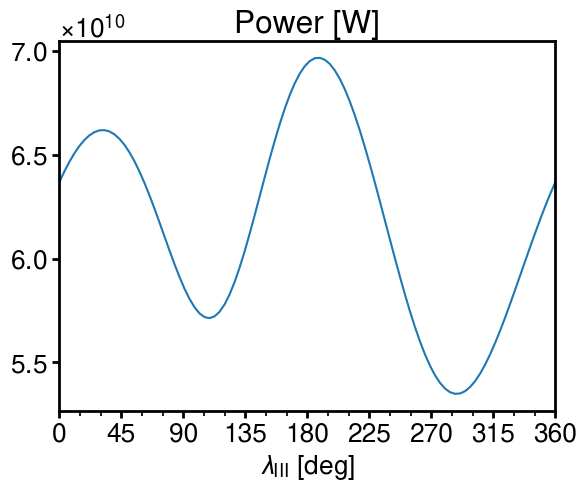

In [131]:
u = 100E+3         # 共回転速度 [m s-1]
rho = 2000         # プラズマ質量密度 [amu cm-3]
rho *= AMU*1E+6    # プラズマ質量密度 [kg m-3]

Sig_A = np.sqrt(rho/(MU0*(B**2)))
E_2 = (u**2)*(Btheta**2 + Br**2)

Pwr = 4*E_2*(RE**2)*Sig_A

fig, ax = plt.subplots()
ax.set_title(r'Power [W]')
ax.set_xlabel(r'$\lambda_{\rm III}$ [deg]', fontsize=19)
ax.set_xlim(0,360)
ax.set_xticks(np.arange(0,361,45,dtype=int))
ax.set_xticklabels(np.arange(0,361,45,dtype=int))
ax.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.yaxis.set_major_formatter(
        ptick.ScalarFormatter(useMathText=True))    # 指数表記
ax.plot(np.degrees(S3wlon), Pwr)

# リード角考慮 Power

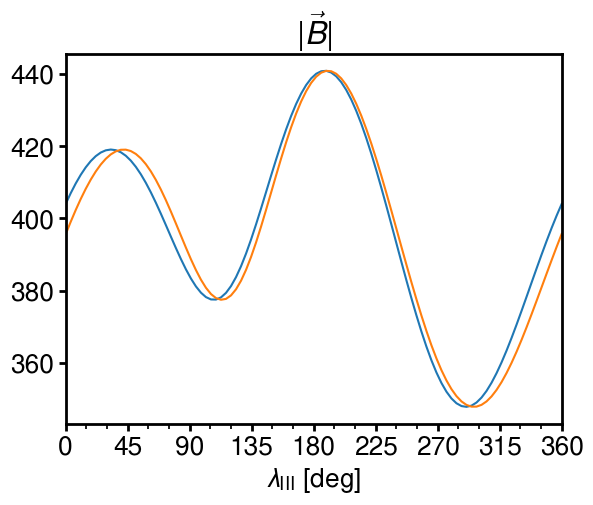

In [132]:
# 衛星公転軌道の磁場強度
S3wlon = np.radians(np.linspace(0, 360, 100))      # [rad]
S3lat = np.zeros(S3wlon.shape)                    # [rad]

theta_arr = 0.5*np.pi-S3lat
phi_arr = 2*np.pi-S3wlon

B = np.zeros(S3wlon.shape)
Br = np.zeros(S3wlon.shape)
Btheta = np.zeros(S3wlon.shape)
Bphi = np.zeros(S3wlon.shape)

x_arr = r_orbit*np.sin(theta_arr)*np.cos(phi_arr)
y_arr = r_orbit*np.sin(theta_arr)*np.sin(phi_arr)
z_arr = r_orbit*np.cos(theta_arr)

for i in range(S3wlon.size):
    theta = theta_arr[i]
    phi = phi_arr[i]
    x = x_arr[i]
    y = y_arr[i]
    z = z_arr[i]

    Bv = BJRM.B().JRM33(r_orbit, theta, phi)*1E-9        # [T]
    Bx = Bv[0]*math.sin(theta)*math.cos(phi) \
        + Bv[1]*math.cos(theta)*math.cos(phi) \
        - Bv[2]*math.sin(phi)
    By = Bv[0]*math.sin(theta)*math.sin(phi) \
        + Bv[1]*math.cos(theta)*math.sin(phi) \
        + Bv[2]*math.cos(phi)
    Bz = Bv[0]*math.cos(theta) - Bv[1]*math.sin(theta)

    Bcs = BJRM.B().BCS(x, y, z, phi)*1E-9  # [T]
    Bx += Bcs[0]
    By += Bcs[1]
    Bz += Bcs[2]

    B0 = math.sqrt(Bx**2+By**2+Bz**2)      # [T]
    Br[i] = Bx*math.sin(theta)*math.cos(phi) \
        +By*math.sin(theta)*math.sin(phi) \
        +Bz*math.cos(theta)
    Btheta[i] = Bx*math.cos(theta)*math.cos(phi) \
        +By*math.cos(theta)*math.sin(phi) \
        -Bz*math.sin(theta)
    Bphi[i] = -Bx*math.sin(phi) + By*math.cos(phi)

    B[i] = B0

    # Br[i], Btheta[i], Bphi[i] = Bv[0], Bv[1], Bv[2]
    # B[i] = math.sqrt(Bv[0]**2 + Bv[1]**2 + Bv[2]**2)

# Hue+2023 fitting
delta = 5.78+3.29*np.cos(0.99*S3wlon)+1.42*np.sin(0.99*S3wlon)
lam3 = np.degrees(S3wlon)-delta
lam3 = np.radians(lam3)
phi_arr = 2*np.pi-lam3

B2 = np.zeros(S3wlon.shape)
Br2 = np.zeros(S3wlon.shape)
Btheta2 = np.zeros(S3wlon.shape)
Bphi2 = np.zeros(S3wlon.shape)

x_arr2 = r_orbit*np.sin(theta_arr)*np.cos(phi_arr)
y_arr2 = r_orbit*np.sin(theta_arr)*np.sin(phi_arr)
z_arr2 = r_orbit*np.cos(theta_arr)

for i in range(S3wlon.size):
    theta = theta_arr[i]
    phi = phi_arr[i]
    x = x_arr2[i]
    y = y_arr2[i]
    z = z_arr2[i]

    Bv = BJRM.B().JRM33(r_orbit, theta, phi)*1E-9        # [T]
    Bx = Bv[0]*math.sin(theta)*math.cos(phi) \
        + Bv[1]*math.cos(theta)*math.cos(phi) \
        - Bv[2]*math.sin(phi)
    By = Bv[0]*math.sin(theta)*math.sin(phi) \
        + Bv[1]*math.cos(theta)*math.sin(phi) \
        + Bv[2]*math.cos(phi)
    Bz = Bv[0]*math.cos(theta) - Bv[1]*math.sin(theta)

    Bcs = BJRM.B().BCS(x, y, z, phi)*1E-9  # [T]
    Bx += Bcs[0]
    By += Bcs[1]
    Bz += Bcs[2]

    B0 = math.sqrt(Bx**2+By**2+Bz**2)      # [T]
    Br2[i] = Bx*math.sin(theta)*math.cos(phi) \
        +By*math.sin(theta)*math.sin(phi) \
        +Bz*math.cos(theta)
    Btheta2[i] = Bx*math.cos(theta)*math.cos(phi) \
        +By*math.cos(theta)*math.sin(phi) \
        -Bz*math.sin(theta)
    Bphi2[i] = -Bx*math.sin(phi) + By*math.cos(phi)

    B2[i] = B0

    # Br2[i], Btheta2[i], Bphi2[i] = Bv[0], Bv[1], Bv[2]
    # B2[i] = math.sqrt(Bv[0]**2 + Bv[1]**2 + Bv[2]**2)

fig, ax = plt.subplots()
ax.set_title(r'$|\vec{B}|$')
ax.set_xlabel(r'$\lambda_{\rm III}$ [deg]', fontsize=19)
ax.set_xlim(0,360)
ax.set_xticks(np.arange(0,361,45,dtype=int))
ax.set_xticklabels(np.arange(0,361,45,dtype=int))
ax.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.plot(np.degrees(S3wlon), B*1E+9)
ax.plot(np.degrees(S3wlon), B2*1E+9)

# np.savetxt('data/Power/B_R4.txt', np.array([np.degrees(S3wlon), B]))

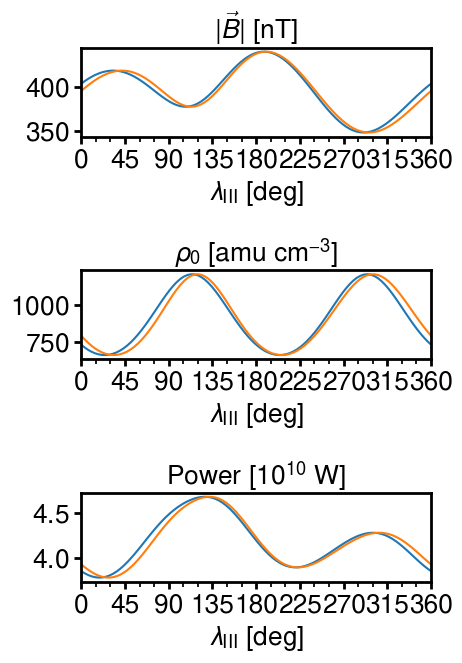

In [133]:
u = 100E+3         # 共回転速度 [m s-1]
Ai = 18            # イオン原子量 [amu]
Ti = 87            # イオン温度 [eV]
rho = 1207         # プラズマ質量密度 [amu cm-3]
rho *= AMU*1E+6    # プラズマ質量密度 [kg m-3]

# 質量密度の計算
# ダイポール座標系に持っていく
# S3RH で Z3軸 の(右ネジ)まわりに-155.8度回転
phiRH0 = math.radians(-155.8)    # Connerney+2020
rvec1 = np.array([
x_arr*math.cos(phiRH0) - y_arr*math.sin(phiRH0),
x_arr*math.sin(phiRH0) + y_arr*math.cos(phiRH0),
z_arr
])

# S3RH で Y3軸 の(右ネジ)まわりに-9.3度回転
THETA_D = math.radians(-6.7)
rvec1 = np.array([
rvec1[0]*math.cos(THETA_D) + rvec1[2]*math.sin(THETA_D),
rvec1[1],
-rvec1[0]*math.sin(THETA_D) + rvec1[2]*math.cos(THETA_D)
])

# 質量密度
H = 2.0*RJ
H0 = 0.64*RJ
H = H0*np.sqrt(Ti/Ai)
rho1 = rho*np.exp(-(rvec1[2]/H)**2)


# 質量密度の計算 - その2
# ダイポール座標系に持っていく
# S3RH で Z3軸 の(右ネジ)まわりに-155.8度回転
phiRH0 = math.radians(-155.8)    # Connerney+2020
rvec2 = np.array([
x_arr2*math.cos(phiRH0) - y_arr2*math.sin(phiRH0),
x_arr2*math.sin(phiRH0) + y_arr2*math.cos(phiRH0),
z_arr2
])

# S3RH で Y3軸 の(右ネジ)まわりに-9.3度回転
THETA_D = math.radians(-6.7)
rvec2 = np.array([
rvec2[0]*math.cos(THETA_D) + rvec2[2]*math.sin(THETA_D),
rvec2[1],
-rvec2[0]*math.sin(THETA_D) + rvec2[2]*math.cos(THETA_D)
])

# 質量密度
rho2 = rho*np.exp(-(rvec2[2]/H)**2)


# リード角考慮あり
Sig_A = np.sqrt(rho1/(MU0*(B**2)))
E_2 = (u**2)*(Btheta**2 + Br**2)
E_2 = (u**2)*(B**2)
Pwr = 4*E_2*(RE**2)*Sig_A

# リード角考慮なし
Sig_A2 = np.sqrt(rho2/(MU0*(B2**2)))
E2_2 = (u**2)*(Btheta2**2 + Br2**2)
E2_2 = (u**2)*(B2**2)
Pwr2 = 4*E2_2*(RE**2)*Sig_A2

fig, ax = plt.subplots(3,1,figsize=(5,7))
for i in range(3):
    ax[i].set_xlabel(r'$\lambda_{\rm III}$ [deg]', fontsize=19)
    ax[i].set_xlim(0,360)
    ax[i].set_xticks(np.arange(0,361,45,dtype=int))
    ax[i].set_xticklabels(np.arange(0,361,45,dtype=int))
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
    ax[i].yaxis.set_major_formatter(
    ptick.ScalarFormatter(useMathText=True))    # 指数表記
        
ax[0].set_title(r'$|\vec{B}|$ [nT]', fontsize=19)
ax[0].plot(np.degrees(S3wlon), B*1E+9)
ax[0].plot(np.degrees(S3wlon), B2*1E+9)

ax[1].set_title(r'$\rho_0$ [amu cm$^{-3}$]', fontsize=19)
ax[1].plot(np.degrees(S3wlon), rho1/(AMU*1E+6))
ax[1].plot(np.degrees(S3wlon), rho2/(AMU*1E+6))

ax[2].set_title(r'Power [$10^{10}$ W]', fontsize=19)
ax[2].plot(np.degrees(S3wlon), (Pwr)*1E-10)
ax[2].plot(np.degrees(S3wlon), (Pwr2)*1E-10)

fig.tight_layout()
plt.show()

# np.savetxt('data/Power/rho_2014_R4.txt', np.array([np.degrees(S3wlon), rho1/(AMU*1E+6)]))
# np.savetxt('data/Power/2014_R4.txt', np.array([np.degrees(S3wlon), Pwr]))

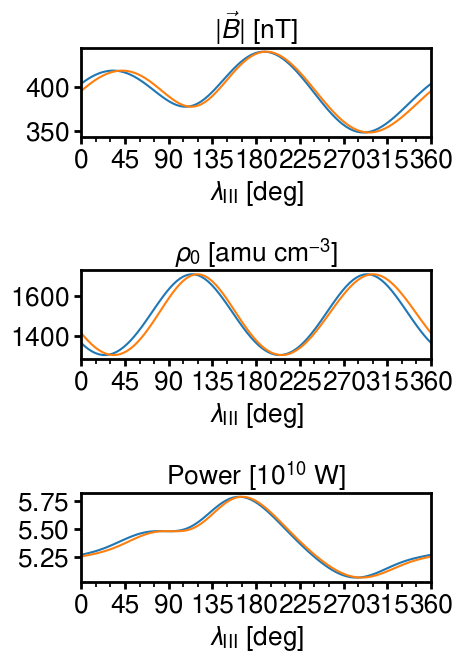

In [134]:
u = 100E+3         # 共回転速度 [m s-1]
Ai = 18            # イオン原子量 [amu]
Ti = 195            # イオン温度 [eV]
rho = 1708         # プラズマ質量密度 [amu cm-3]
rho *= AMU*1E+6    # プラズマ質量密度 [kg m-3]

# 質量密度の計算
# ダイポール座標系に持っていく
# S3RH で Z3軸 の(右ネジ)まわりに-155.8度回転
phiRH0 = math.radians(-155.8)    # Connerney+2020
rvec1 = np.array([
x_arr*math.cos(phiRH0) - y_arr*math.sin(phiRH0),
x_arr*math.sin(phiRH0) + y_arr*math.cos(phiRH0),
z_arr
])

# S3RH で Y3軸 の(右ネジ)まわりに-9.3度回転
THETA_D = math.radians(-6.7)
rvec1 = np.array([
rvec1[0]*math.cos(THETA_D) + rvec1[2]*math.sin(THETA_D),
rvec1[1],
-rvec1[0]*math.sin(THETA_D) + rvec1[2]*math.cos(THETA_D)
])

# 質量密度
H = 2.0*RJ
H0 = 0.64*RJ
H = H0*np.sqrt(Ti/Ai)
rho1 = rho*np.exp(-(rvec1[2]/H)**2)


# 質量密度の計算 - その2
# ダイポール座標系に持っていく
# S3RH で Z3軸 の(右ネジ)まわりに-155.8度回転
phiRH0 = math.radians(-155.8)    # Connerney+2020
rvec2 = np.array([
x_arr2*math.cos(phiRH0) - y_arr2*math.sin(phiRH0),
x_arr2*math.sin(phiRH0) + y_arr2*math.cos(phiRH0),
z_arr2
])

# S3RH で Y3軸 の(右ネジ)まわりに-9.3度回転
THETA_D = math.radians(-6.7)
rvec2 = np.array([
rvec2[0]*math.cos(THETA_D) + rvec2[2]*math.sin(THETA_D),
rvec2[1],
-rvec2[0]*math.sin(THETA_D) + rvec2[2]*math.cos(THETA_D)
])

# 質量密度
rho2 = rho*np.exp(-(rvec2[2]/H)**2)


# リード角考慮あり
Sig_A = np.sqrt(rho1/(MU0*(B**2)))
E_2 = (u**2)*(Btheta**2 + Br**2)
E_2 = (u**2)*(B**2)
Pwr = 4*E_2*(RE**2)*Sig_A

# リード角考慮なし
Sig_A2 = np.sqrt(rho2/(MU0*(B2**2)))
E2_2 = (u**2)*(Btheta2**2 + Br2**2)
E2_2 = (u**2)*(B2**2)
Pwr2 = 4*E2_2*(RE**2)*Sig_A2

fig, ax = plt.subplots(3,1,figsize=(5,7))
for i in range(3):
    ax[i].set_xlabel(r'$\lambda_{\rm III}$ [deg]', fontsize=19)
    ax[i].set_xlim(0,360)
    ax[i].set_xticks(np.arange(0,361,45,dtype=int))
    ax[i].set_xticklabels(np.arange(0,361,45,dtype=int))
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
    ax[i].yaxis.set_major_formatter(
    ptick.ScalarFormatter(useMathText=True))    # 指数表記
        
ax[0].set_title(r'$|\vec{B}|$ [nT]', fontsize=19)
ax[0].plot(np.degrees(S3wlon), B*1E+9)
ax[0].plot(np.degrees(S3wlon), B2*1E+9)

ax[1].set_title(r'$\rho_0$ [amu cm$^{-3}$]', fontsize=19)
ax[1].plot(np.degrees(S3wlon), rho1/(AMU*1E+6))
ax[1].plot(np.degrees(S3wlon), rho2/(AMU*1E+6))

ax[2].set_title(r'Power [$10^{10}$ W]', fontsize=19)
ax[2].plot(np.degrees(S3wlon), (Pwr)*1E-10)
ax[2].plot(np.degrees(S3wlon), (Pwr2)*1E-10)

fig.tight_layout()
plt.show()

# np.savetxt('data/Power/rho_2022_R4.txt', np.array([np.degrees(S3wlon), rho1/(AMU*1E+6)]))
# np.savetxt('data/Power/2022_R4.txt', np.array([np.degrees(S3wlon), Pwr]))

# 2014と2022の比較

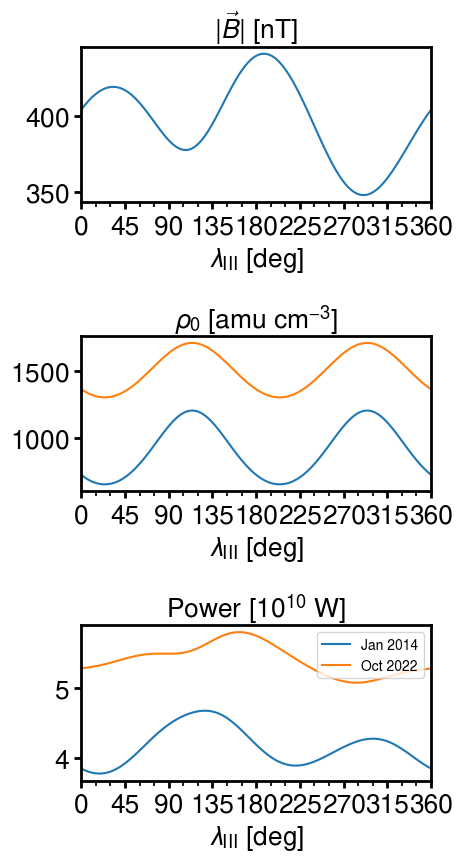

In [135]:
u = 100E+3               # 共回転速度 [m s-1]
Ai = 18                  # イオン原子量 [amu]
Ti1 = 87                 # イオン温度 [eV]
Ti2 = 195                # イオン温度 [eV]
rho01 = 1207*AMU*1E+6    # プラズマ質量密度 [amu cm-3]
rho02 = 1708*AMU*1E+6    # プラズマ質量密度 [amu cm-3]

H0 = 0.64*RJ
H1 = H0*np.sqrt(Ti1/Ai)
H2 = H0*np.sqrt(Ti2/Ai)

# 質量密度の計算
# ダイポール座標系に持っていく
# S3RH で Z3軸 の(右ネジ)まわりに-155.8度回転
phiRH0 = math.radians(-155.8)    # Connerney+2020
rvec1 = np.array([
x_arr*math.cos(phiRH0) - y_arr*math.sin(phiRH0),
x_arr*math.sin(phiRH0) + y_arr*math.cos(phiRH0),
z_arr
])

# S3RH で Y3軸 の(右ネジ)まわりに-9.3度回転
THETA_D = math.radians(-6.7)
rvec1 = np.array([
rvec1[0]*math.cos(THETA_D) + rvec1[2]*math.sin(THETA_D),
rvec1[1],
-rvec1[0]*math.sin(THETA_D) + rvec1[2]*math.cos(THETA_D)
])

# 質量密度
rho1 = rho01*np.exp(-(rvec1[2]/H1)**2)
rho2 = rho02*np.exp(-(rvec1[2]/H2)**2)


# 2014
Sig_A = np.sqrt(rho1/(MU0*(B**2)))
E_2 = (u**2)*(Btheta**2 + Br**2)
E_2 = (u**2)*(B**2)
Pwr1 = 4*E_2*(RE**2)*Sig_A

# 2022
Sig_A = np.sqrt(rho2/(MU0*(B**2)))
E_2 = (u**2)*(Btheta**2 + Br**2)
E_2 = (u**2)*(B**2)
Pwr2 = 4*E_2*(RE**2)*Sig_A

fig, ax = plt.subplots(3,1,figsize=(5,9), dpi=100)
for i in range(3):
    ax[i].set_xlabel(r'$\lambda_{\rm III}$ [deg]', fontsize=19)
    ax[i].set_xlim(0,360)
    ax[i].set_xticks(np.arange(0,361,45,dtype=int))
    ax[i].set_xticklabels(np.arange(0,361,45,dtype=int))
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
    ax[i].yaxis.set_major_formatter(
    ptick.ScalarFormatter(useMathText=True))    # 指数表記
        
ax[0].set_title(r'$|\vec{B}|$ [nT]', fontsize=19)
ax[0].plot(np.degrees(S3wlon), B*1E+9)

ax[1].set_title(r'$\rho_0$ [amu cm$^{-3}$]', fontsize=19)
ax[1].plot(np.degrees(S3wlon), rho1/(AMU*1E+6))
ax[1].plot(np.degrees(S3wlon), rho2/(AMU*1E+6))

ax[2].set_title(r'Power [$10^{10}$ W]', fontsize=19)
ax[2].plot(np.degrees(S3wlon), (Pwr1)*1E-10, label='Jan 2014')
ax[2].plot(np.degrees(S3wlon), (Pwr2)*1E-10, label='Oct 2022')
ax[2].legend(loc='upper right', fontsize=10)

fig.tight_layout()
plt.show()

# 2014 BRIGHTNESS FITTING

In [136]:
# 観測量 (平均値)
S3wlon_14 = np.array([133.42524957613273, 98.28193689058392, 187.72694177182828])       # [deg]
brightness_14 = np.array([148.69104156172097, 119.48405134898138, 85.2057683162894])    # [kR]
one_sigma_14 = np.array([35.95013950014683, 34.19465180990543, 21.60489879738368])      # [kR]

# プラズマシートパラメータ
u = 100E+3               # 共回転速度 [m s-1]
Ai = 18                  # イオン原子量 [amu]
Ti1 = 87                 # イオン温度 [eV]
rho01 = 1207*AMU*1E+6    # プラズマ質量密度 [amu cm-3]
H0 = 0.64*RJ
H1 = H0*np.sqrt(Ti1/Ai)

# フィッティング用のベース作成
Pwr1 = np.zeros(3)
for j in range(3):
    theta = math.radians(90)
    phi = math.radians(360-S3wlon_14[j])
    x = r_orbit*math.sin(theta)*math.cos(phi)
    y = r_orbit*math.sin(theta)*math.sin(phi)
    z = r_orbit*math.cos(theta)

    Bv = BJRM.B().JRM33(r_orbit, theta, phi)*1E-9        # [T]
    Bx = Bv[0]*math.sin(theta)*math.cos(phi) \
        + Bv[1]*math.cos(theta)*math.cos(phi) \
        - Bv[2]*math.sin(phi)
    By = Bv[0]*math.sin(theta)*math.sin(phi) \
        + Bv[1]*math.cos(theta)*math.sin(phi) \
        + Bv[2]*math.cos(phi)
    Bz = Bv[0]*math.cos(theta) - Bv[1]*math.sin(theta)

    Bcs = BJRM.B().BCS(x, y, z, phi)*1E-9  # [T]
    Bx += Bcs[0]
    By += Bcs[1]
    Bz += Bcs[2]

    B0 = math.sqrt(Bx**2+By**2+Bz**2)      # [T]

    # ダイポール座標系に持っていく
    # S3RH で Z3軸 の(右ネジ)まわりに-155.8度回転
    phiRH0 = math.radians(-155.8)    # Connerney+2020
    rvec1 = np.array([
    x*math.cos(phiRH0) - y*math.sin(phiRH0),
    x*math.sin(phiRH0) + y*math.cos(phiRH0),
    z
    ])

    # S3RH で Y3軸 の(右ネジ)まわりに-9.3度回転
    THETA_D = math.radians(-6.7)
    rvec1 = np.array([
    rvec1[0]*math.cos(THETA_D) + rvec1[2]*math.sin(THETA_D),
    rvec1[1],
    -rvec1[0]*math.sin(THETA_D) + rvec1[2]*math.cos(THETA_D)
    ])

    # 質量密度
    rho1 = rho01*math.exp(-(rvec1[2]/H1)**2)

    # 2014
    Sig_A = np.sqrt(rho1/(MU0*(B0**2)))
    E_2 = (u**2)*(B0**2)
    Pwr1[j] = 4*E_2*(RE**2)*Sig_A


# Powerのベース
baseline = Pwr1*(1E-10)*20

[84.01120418 81.93660542 73.7571836 ]
[85.34471536 83.23718646 74.92793255]
[86.67822653 84.5377675  76.09868149]
[88.01173771 85.83834854 77.26943044]
[89.34524889 87.13892958 78.44017939]
[90.67876007 88.43951062 79.61092833]
[92.01227124 89.74009165 80.78167728]
[93.34578242 91.04067269 81.95242622]
[94.6792936  92.34125373 83.12317517]
[96.01280478 93.64183477 84.29392412]
[97.34631595 94.94241581 85.46467306]
[98.67982713 96.24299685 86.63542201]
[100.01333831  97.54357788  87.80617096]
[101.34684949  98.84415892  88.9769199 ]
[102.68036066 100.14473996  90.14766885]
[104.01387184 101.445321    91.31841779]
[105.34738302 102.74590204  92.48916674]
[106.6808942  104.04648308  93.65991569]
[108.01440537 105.34706411  94.83066463]
[109.34791655 106.64764515  96.00141358]
[110.68142773 107.94822619  97.17216252]
[112.01493891 109.24880723  98.34291147]
[113.34845008 110.54938827  99.51366042]
[114.68196126 111.84996931 100.68440936]
[116.01547244 113.15055035 101.85515831]
[117.348983

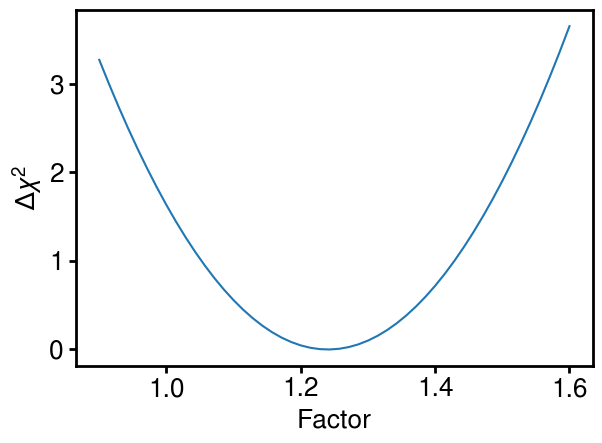

2014 Best-fit factor: 1.2428571428571429
Chi2: 1.454301033474918
2.485714285714286e-09


In [137]:
# フィッティング
N = 50
factor = np.linspace(0.9,1.6,N)
chi2_arr = np.zeros(N)
for k in range(N):
    obj = baseline*factor[k]
    print(obj)
    chi2 = np.sum(((brightness_14-obj)/(one_sigma_14))**2)
    chi2_arr[k] = chi2 

fig, ax = plt.subplots()
ax.set_xlabel('Factor')
ax.set_ylabel(r'$\Delta \chi^2$')
ax.plot(factor,chi2_arr-np.min(chi2_arr))
fig.tight_layout()
plt.show()

min_idx = np.where(chi2_arr==np.min(chi2_arr))
min_factor = factor[min_idx][0]
print('2014 Best-fit factor:', min_factor)
print('Chi2:', chi2_arr[min_idx][0])
print(min_factor*(1E-10)*20)

# 等高線のふちでテスト

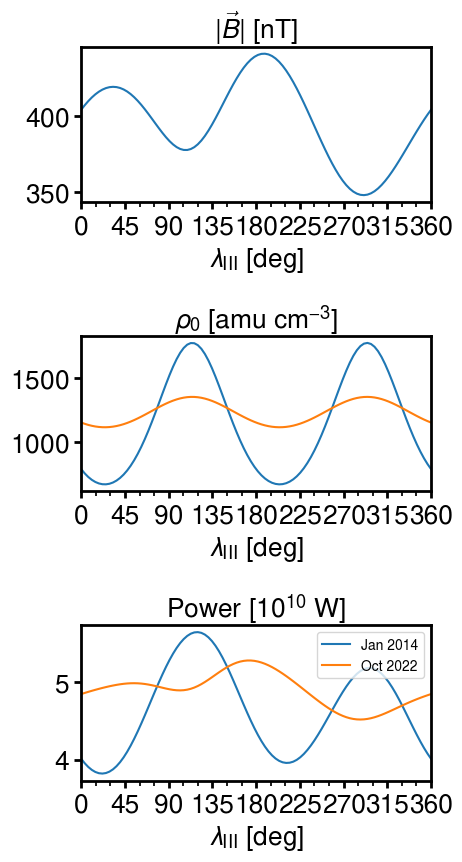

In [138]:
u = 100E+3               # 共回転速度 [m s-1]
Ai = 18                  # イオン原子量 [amu]
Ti1 = 54                 # イオン温度 [eV]
Ti2 = 273                # イオン温度 [eV]
rho01 = 1776*AMU*1E+6    # プラズマ質量密度 [amu cm-3]
rho02 = 1354*AMU*1E+6    # プラズマ質量密度 [amu cm-3]

H0 = 0.64*RJ
H1 = H0*np.sqrt(Ti1/Ai)
H2 = H0*np.sqrt(Ti2/Ai)

# 質量密度の計算
# ダイポール座標系に持っていく
# S3RH で Z3軸 の(右ネジ)まわりに-155.8度回転
phiRH0 = math.radians(-155.8)    # Connerney+2020
rvec1 = np.array([
x_arr*math.cos(phiRH0) - y_arr*math.sin(phiRH0),
x_arr*math.sin(phiRH0) + y_arr*math.cos(phiRH0),
z_arr
])

# S3RH で Y3軸 の(右ネジ)まわりに-9.3度回転
THETA_D = math.radians(-6.7)
rvec1 = np.array([
rvec1[0]*math.cos(THETA_D) + rvec1[2]*math.sin(THETA_D),
rvec1[1],
-rvec1[0]*math.sin(THETA_D) + rvec1[2]*math.cos(THETA_D)
])

# 質量密度
rho1 = rho01*np.exp(-(rvec1[2]/H1)**2)
rho2 = rho02*np.exp(-(rvec1[2]/H2)**2)


# 2014
Sig_A = np.sqrt(rho1/(MU0*(B**2)))
E_2 = (u**2)*(Btheta**2 + Br**2)
E_2 = (u**2)*(B**2)
Pwr1 = 4*E_2*(RE**2)*Sig_A

# 2022
Sig_A = np.sqrt(rho2/(MU0*(B**2)))
E_2 = (u**2)*(Btheta**2 + Br**2)
E_2 = (u**2)*(B**2)
Pwr2 = 4*E_2*(RE**2)*Sig_A

fig, ax = plt.subplots(3,1,figsize=(5,9), dpi=100)
for i in range(3):
    ax[i].set_xlabel(r'$\lambda_{\rm III}$ [deg]', fontsize=19)
    ax[i].set_xlim(0,360)
    ax[i].set_xticks(np.arange(0,361,45,dtype=int))
    ax[i].set_xticklabels(np.arange(0,361,45,dtype=int))
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
    ax[i].yaxis.set_major_formatter(
    ptick.ScalarFormatter(useMathText=True))    # 指数表記
        
ax[0].set_title(r'$|\vec{B}|$ [nT]', fontsize=19)
ax[0].plot(np.degrees(S3wlon), B*1E+9)

ax[1].set_title(r'$\rho_0$ [amu cm$^{-3}$]', fontsize=19)
ax[1].plot(np.degrees(S3wlon), rho1/(AMU*1E+6))
ax[1].plot(np.degrees(S3wlon), rho2/(AMU*1E+6))

ax[2].set_title(r'Power [$10^{10}$ W]', fontsize=19)
ax[2].plot(np.degrees(S3wlon), (Pwr1)*1E-10, label='Jan 2014')
ax[2].plot(np.degrees(S3wlon), (Pwr2)*1E-10, label='Oct 2022')
ax[2].legend(loc='upper right', fontsize=10)

fig.tight_layout()
plt.show()

# np.savetxt('data/Power/rho_2014_R4_test1.txt', np.array([np.degrees(S3wlon), rho1/(AMU*1E+6)]))
# np.savetxt('data/Power/2014_R4_test1.txt', np.array([np.degrees(S3wlon), Pwr1]))
# np.savetxt('data/Power/rho_2022_R4_test1.txt', np.array([np.degrees(S3wlon), rho2/(AMU*1E+6)]))
# np.savetxt('data/Power/2022_R4_test1.txt', np.array([np.degrees(S3wlon), Pwr2]))

[99.88510347 98.01833056 75.48298906]
[101.4705813   99.57417707  76.68113175]
[103.05605913 101.13002359  77.87927443]
[104.64153697 102.68587011  79.07741712]
[106.2270148  104.24171662  80.2755598 ]
[107.81249263 105.79756314  81.47370248]
[109.39797047 107.35340966  82.67184517]
[110.9834483  108.90925617  83.86998785]
[112.56892613 110.46510269  85.06813053]
[114.15440396 112.02094921  86.26627322]
[115.7398818  113.57679572  87.4644159 ]
[117.32535963 115.13264224  88.66255858]
[118.91083746 116.68848876  89.86070127]
[120.49631529 118.24433527  91.05884395]
[122.08179313 119.80018179  92.25698663]
[123.66727096 121.35602831  93.45512932]
[125.25274879 122.91187482  94.653272  ]
[126.83822663 124.46772134  95.85141468]
[128.42370446 126.02356786  97.04955737]
[130.00918229 127.57941437  98.24770005]
[131.59466012 129.13526089  99.44584274]
[133.18013796 130.69110741 100.64398542]
[134.76561579 132.24695393 101.8421281 ]
[136.35109362 133.80280044 103.04027079]
[137.93657146 135.3

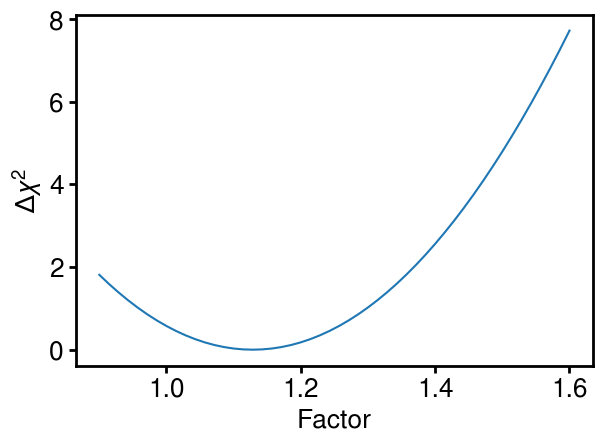

2014 Best-fit factor: 1.1285714285714286
Chi2: 0.626327880725378
2.257142857142857e-09


In [139]:
# 観測量 (平均値)
S3wlon_14 = np.array([133.42524957613273, 98.28193689058392, 187.72694177182828])       # [deg]
brightness_14 = np.array([148.69104156172097, 119.48405134898138, 85.2057683162894])    # [kR]
one_sigma_14 = np.array([35.95013950014683, 34.19465180990543, 21.60489879738368])      # [kR]

# プラズマシートパラメータ
u = 100E+3               # 共回転速度 [m s-1]
Ai = 18                  # イオン原子量 [amu]
H0 = 0.64*RJ
H1 = H0*np.sqrt(Ti1/Ai)

# フィッティング用のベース作成
Pwr1 = np.zeros(3)
for j in range(3):
    theta = math.radians(90)
    phi = math.radians(360-S3wlon_14[j])
    x = r_orbit*math.sin(theta)*math.cos(phi)
    y = r_orbit*math.sin(theta)*math.sin(phi)
    z = r_orbit*math.cos(theta)

    Bv = BJRM.B().JRM33(r_orbit, theta, phi)*1E-9        # [T]
    Bx = Bv[0]*math.sin(theta)*math.cos(phi) \
        + Bv[1]*math.cos(theta)*math.cos(phi) \
        - Bv[2]*math.sin(phi)
    By = Bv[0]*math.sin(theta)*math.sin(phi) \
        + Bv[1]*math.cos(theta)*math.sin(phi) \
        + Bv[2]*math.cos(phi)
    Bz = Bv[0]*math.cos(theta) - Bv[1]*math.sin(theta)

    Bcs = BJRM.B().BCS(x, y, z, phi)*1E-9  # [T]
    Bx += Bcs[0]
    By += Bcs[1]
    Bz += Bcs[2]

    B0 = math.sqrt(Bx**2+By**2+Bz**2)      # [T]

    # ダイポール座標系に持っていく
    # S3RH で Z3軸 の(右ネジ)まわりに-155.8度回転
    phiRH0 = math.radians(-155.8)    # Connerney+2020
    rvec1 = np.array([
    x*math.cos(phiRH0) - y*math.sin(phiRH0),
    x*math.sin(phiRH0) + y*math.cos(phiRH0),
    z
    ])

    # S3RH で Y3軸 の(右ネジ)まわりに-9.3度回転
    THETA_D = math.radians(-6.7)
    rvec1 = np.array([
    rvec1[0]*math.cos(THETA_D) + rvec1[2]*math.sin(THETA_D),
    rvec1[1],
    -rvec1[0]*math.sin(THETA_D) + rvec1[2]*math.cos(THETA_D)
    ])

    # 質量密度
    rho1 = rho01*math.exp(-(rvec1[2]/H1)**2)

    # 2014
    Sig_A = np.sqrt(rho1/(MU0*(B0**2)))
    E_2 = (u**2)*(B0**2)
    Pwr1[j] = 4*E_2*(RE**2)*Sig_A


# Powerのベース
baseline = Pwr1*(1E-10)*20

# フィッティング
N = 50
factor = np.linspace(0.9,1.6,N)
chi2_arr = np.zeros(N)
for k in range(N):
    obj = baseline*factor[k]
    print(obj)
    chi2 = np.sum(((brightness_14-obj)/(one_sigma_14))**2)
    chi2_arr[k] = chi2 

fig, ax = plt.subplots()
ax.set_xlabel('Factor')
ax.set_ylabel(r'$\Delta \chi^2$')
ax.plot(factor,chi2_arr-np.min(chi2_arr))
fig.tight_layout()
plt.show()

min_idx = np.where(chi2_arr==np.min(chi2_arr))
min_factor = factor[min_idx][0]
print('2014 Best-fit factor:', min_factor)
print('Chi2:', chi2_arr[min_idx][0])
print(min_factor*(1E-10)*20)

# 等高線のふち


In [140]:
"""
14 ===
Rho
[1303.60557713  920.52383102  788.63221675 1206.60730149  852.02978201
 1408.40147298 1581.60074835 1206.60730149  788.63221675 1581.60074835
 1116.82644318 1160.84923261]
Ti
[ 71.54245234 130.84708648 139.92567679  93.56151816 122.3575289
  81.81454916  62.56005246 100.05311621 149.63416879  66.90066944
  87.49110484 106.99512214]
22 ===
Rho
[1581.60074835 1643.94389677 1581.60074835 1994.51654932 1846.10918638
 1521.621834   1463.91749505 1846.10918638 1354.99078042 1463.91749505
 1846.10918638 1846.10918638]
Ti
[195.68800819 182.99147318 223.78497859 149.63416879 182.99147318
 209.26546949 273.67240544 195.68800819 273.67240544 255.91612437
 160.01626708 160.01626708]
"""

u = 100E+3               # 共回転速度 [m s-1]
Ai = 18                  # イオン原子量 [amu]

rho01_arr = np.array([
    920.52383102, 788.63221675, 1206.60730149, 852.02978201,
    1408.40147298, 1581.60074835, 1206.60730149, 788.63221675, 1581.60074835,
    1116.82644318])
rho01_arr *= AMU*1E+6
Ti1_arr = np.array([130.84708648, 139.92567679, 93.56151816, 122.3575289, 
                    81.81454916, 62.56005246, 100.05311621, 149.63416879, 66.90066944, 
                    87.49110484])

rho02_arr = np.array([1581.60074835, 1581.60074835, 1994.51654932, 
                  1846.10918638, 1521.621834, 1463.91749505, 1846.10918638, 1354.99078042,
                  1463.91749505, 1846.10918638])
rho02_arr *= AMU*1E+6
Ti2_arr = np.array([195.68800819, 223.78497859, 149.63416879, 182.99147318,
                    209.26546949, 273.67240544, 195.68800819, 273.67240544, 255.91612437, 
                    160.01626708])

for i in range(rho01_arr.size):
    rho01 = rho01_arr[i]
    Ti1 = Ti1_arr[i]

    rho02 = rho02_arr[i]
    Ti2 = Ti2_arr[i]

    H0 = 0.64*RJ
    H1 = H0*np.sqrt(Ti1/Ai)
    H2 = H0*np.sqrt(Ti2/Ai)

    # 質量密度の計算
    # ダイポール座標系に持っていく
    # S3RH で Z3軸 の(右ネジ)まわりに-155.8度回転
    phiRH0 = math.radians(-155.8)    # Connerney+2020
    rvec1 = np.array([
    x_arr*math.cos(phiRH0) - y_arr*math.sin(phiRH0),
    x_arr*math.sin(phiRH0) + y_arr*math.cos(phiRH0),
    z_arr
    ])

    # S3RH で Y3軸 の(右ネジ)まわりに-9.3度回転
    THETA_D = math.radians(-6.7)
    rvec1 = np.array([
    rvec1[0]*math.cos(THETA_D) + rvec1[2]*math.sin(THETA_D),
    rvec1[1],
    -rvec1[0]*math.sin(THETA_D) + rvec1[2]*math.cos(THETA_D)
    ])

    # 質量密度
    rho1 = rho01*np.exp(-(rvec1[2]/H1)**2)
    rho2 = rho02*np.exp(-(rvec1[2]/H2)**2)


    # 2014
    Sig_A = np.sqrt(rho1/(MU0*(B**2)))
    E_2 = (u**2)*(Btheta**2 + Br**2)
    E_2 = (u**2)*(B**2)
    Pwr1 = 4*E_2*(RE**2)*Sig_A

    # 2022
    Sig_A = np.sqrt(rho2/(MU0*(B**2)))
    E_2 = (u**2)*(Btheta**2 + Br**2)
    E_2 = (u**2)*(B**2)
    Pwr2 = 4*E_2*(RE**2)*Sig_A

    np.savetxt('data/Power/rho_2014_R4_rand'+str(i)+'.txt', np.array([np.degrees(S3wlon), rho1/(AMU*1E+6)]))
    np.savetxt('data/Power/2014_R4_rand'+str(i)+'.txt', np.array([np.degrees(S3wlon), Pwr1]))
    np.savetxt('data/Power/rho_2022_R4_rand'+str(i)+'.txt', np.array([np.degrees(S3wlon), rho2/(AMU*1E+6)]))
    np.savetxt('data/Power/2022_R4_rand'+str(i)+'.txt', np.array([np.degrees(S3wlon), Pwr2]))